Data Source: https://data.cityofchicago.org/Public-Safety/Chicago-Police-Department-Illinois-Uniform-Crime-R/c7ck-438e

In this script I calculate the distance of each crime report from the center of Chicago and the closest police station. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import KDTree, BallTree, DistanceMetric
import matplotlib.pyplot as plt
%matplotlib inline 
pd.options.display.max_columns = 1000

In [2]:
# Reading in the crime data csv file and converting to a dataframe
crime_df = pd.read_csv('Crimes_2001_into_2018_Cleaned.csv')

In [5]:
crime_df.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km),Closest Liquor Store,Distance from Closest Liquor Store (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54,Cicero & Ohio,0.10,MAZE FOOD & LIQUOR INC,0.10
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62,Ashland & 66th Street,0.12,"BIG SAM'S FOOD & LIQUOR, INC.",0.53
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88,Oakenwald & 43rd Street,0.35,"ONE STOP FOOD & LIQUOR STORE, INC.",0.37
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37,51st Street & Michigan,0.13,51ST EXPRESS FOOD & LIQUOR INC,0.15
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74,Jackson & Kilpatrick,0.13,"NIJAR FOOD & LIQUOR, INC.",0.70


## Distance from Chicago

In [6]:
# Defining function
def haversine(lat1, lon1, lat2, lon2):
    """Calculates the distance between two lat/lon positions"""
    R = 6371 # mean Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2]) # converting lat/lon from degrees to radians
    
    phi_1 = lat1
    phi_2 = lat2
    
    delta_phi = lat2 - lat1
    delta_lambda = lon2 - lon1
    
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return round((R * c), 2) # returns the distance in km rounded to the nearest hundredth

In [7]:
# Calculating the distance of each crime from Chicago
# The coordinates used for Chicago are from https://www.latlong.net/place/chicago-il-usa-1855.html
chicago_lat = 41.881832
chicago_lon = -87.623177

crime_df['Distance from Chicago (km)'] = crime_df.apply(lambda row: haversine(chicago_lat, chicago_lon, row['Latitude'], row['Longitude']), axis = 1) 

In [8]:
crime_df.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km),Closest Liquor Store,Distance from Closest Liquor Store (km),Distance from Chicago (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54,Cicero & Ohio,0.10,MAZE FOOD & LIQUOR INC,0.10,10.09
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62,Ashland & 66th Street,0.12,"BIG SAM'S FOOD & LIQUOR, INC.",0.53,12.56
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88,Oakenwald & 43rd Street,0.35,"ONE STOP FOOD & LIQUOR STORE, INC.",0.37,7.87
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37,51st Street & Michigan,0.13,51ST EXPRESS FOOD & LIQUOR INC,0.15,9.01
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74,Jackson & Kilpatrick,0.13,"NIJAR FOOD & LIQUOR, INC.",0.70,9.96


## Distance from Closest Police Station

In [3]:
# Reading in the police station csv file and converting to a dataframe
police_df = pd.read_csv('Police_Stations.csv')

In [4]:
police_df

,DISTRICT,ADDRESS,CITY,STATE,ZIP,WEBSITE,LOCATION
0,1,1718 S State St,Chicago,IL,60616,http://home.chicagopolice.org/community/distri...,"(41.8583725929, -87.627356171)"
1,2,5101 S Wentworth Ave,Chicago,IL,60609,http://home.chicagopolice.org/community/distri...,"(41.8018110912, -87.6305601801)"
2,3,7040 S Cottage Grove Ave,Chicago,IL,60637,http://home.chicagopolice.org/community/distri...,"(41.7664308925, -87.6057478606)"
3,4,2255 E 103rd St,Chicago,IL,60617,http://home.chicagopolice.org/community/distri...,"(41.7079332906, -87.5683491228)"
4,5,727 E 111th St,Chicago,IL,60628,http://home.chicagopolice.org/community/distri...,"(41.6927233639, -87.6045058667)"
5,6,7808 S Halsted St,Chicago,IL,60620,http://home.chicagopolice.org/community/distri...,"(41.7521368378, -87.6442289066)"
6,7,1438 W 63rd St,Chicago,IL,60636,http://home.chicagopolice.org/community/distri...,"(41.7796315359, -87.6608870173)"
7,8,3420 W 63rd St,Chicago,IL,60629,http://home.chicagopolice.org/community/distri...,"(41.778987189, -87.7088638153)"
8,9,3120 S Halsted St,Chicago,IL,60608,http://home.chicagopolice.org/community/distri...,"(41.8373944311, -87.6464077068)"
9,10,3315 W Ogden Ave,Chicago,IL,60623,http://home.chicagopolice.org/community/distri...,"(41.8566845327, -87.708381958)"


In [8]:
police_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 9 columns):
DISTRICT     22 non-null object
ADDRESS      22 non-null object
CITY         22 non-null object
STATE        22 non-null object
ZIP          22 non-null int64
WEBSITE      22 non-null object
LOCATION     22 non-null object
LATITUDE     22 non-null float64
LONGITUDE    22 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 1.7+ KB


In [5]:
# Excluding the police headquarters
police_df = police_df.drop(police_df.index[[22]])

In [6]:
# Splitting the latitude and longitude from 'LOCATION'
latitude = []
longitude = []
for item in police_df['LOCATION']: 
    lat, lon = item.strip('()').split(',')
    latitude.append(float(lat))
    longitude.append(float(lon))

# Creating columns for latitude and longitude
police_df['LATITUDE'] = latitude
police_df['LONGITUDE'] = longitude

Text(0,0.5,'Latitude')

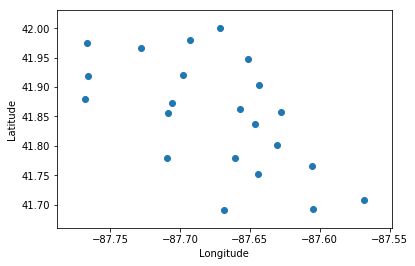

In [7]:
# plotting lat/long to make sure there are no bad points
plt.scatter(x=police_df['LONGITUDE'], y=police_df['LATITUDE'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [13]:
police_df.head()

,DISTRICT,ADDRESS,CITY,STATE,ZIP,WEBSITE,LOCATION,LATITUDE,LONGITUDE
0,1,1718 S State St,Chicago,IL,60616,http://home.chicagopolice.org/community/distri...,"(41.8583725929, -87.627356171)",41.858373,-87.627356
1,2,5101 S Wentworth Ave,Chicago,IL,60609,http://home.chicagopolice.org/community/distri...,"(41.8018110912, -87.6305601801)",41.801811,-87.630560
2,3,7040 S Cottage Grove Ave,Chicago,IL,60637,http://home.chicagopolice.org/community/distri...,"(41.7664308925, -87.6057478606)",41.766431,-87.605748
3,4,2255 E 103rd St,Chicago,IL,60617,http://home.chicagopolice.org/community/distri...,"(41.7079332906, -87.5683491228)",41.707933,-87.568349
4,5,727 E 111th St,Chicago,IL,60628,http://home.chicagopolice.org/community/distri...,"(41.6927233639, -87.6045058667)",41.692723,-87.604506


In [14]:
# Creating a temporary dataframe with non-null entries of latitude and longitude
crime_df_notnull = crime_df[pd.notnull(crime_df['Latitude'])]

# Resetting the index for crime_df_notnull before moving on
crime_df_notnull = crime_df_notnull.reset_index(drop = True)

In [15]:
# Converting the police station coordinates to radians and zipping them together 
police = list(zip(np.deg2rad(police_df['LATITUDE']), np.deg2rad(police_df['LONGITUDE'])))

# The BallTree is created using the police coordinates
tree = BallTree(police, metric = DistanceMetric.get_metric('haversine'))

# Converting the crime coordinates to radians and zipping them together
crime = list(zip(np.deg2rad(crime_df_notnull['Latitude']), np.deg2rad(crime_df_notnull['Longitude'])))

In [16]:
# Finding the closest police station for each crime
dists, ind = tree.query(crime, k=1) # returns distance and index of nearest police station

# Extracting the nearest police station (district) from ind
index = list(ind[:,0])
stations = list(police_df['DISTRICT'][index])

# Extracting the distance from the nearest police station from dists and converting from radians to km
distances = list((dists[:,0] * 6371).round(2))

In [17]:
# Creating new columns
crime_df_notnull['Closest Police Station (District)'] = stations
crime_df_notnull['Distance from Closest Police Station (km)'] = distances

In [18]:
crime_df_notnull.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km),Closest Liquor Store,Distance from Closest Liquor Store (km),Distance from Chicago (km),Closest Police Station (District),Distance from Closest Police Station (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54,Cicero & Ohio,0.10,MAZE FOOD & LIQUOR INC,0.10,10.09,15,2.34
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62,Ashland & 66th Street,0.12,"BIG SAM'S FOOD & LIQUOR, INC.",0.53,12.56,7,0.79
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88,Oakenwald & 43rd Street,0.35,"ONE STOP FOOD & LIQUOR STORE, INC.",0.37,7.87,2,3.11
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37,51st Street & Michigan,0.13,51ST EXPRESS FOOD & LIQUOR INC,0.15,9.01,2,0.67
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74,Jackson & Kilpatrick,0.13,"NIJAR FOOD & LIQUOR, INC.",0.70,9.96,15,2.07


In [19]:
crime_df.columns

Index(['ID', 'Date', 'Year', 'Block', 'Primary Type', 'Location Description',
       'Domestic', 'Beat', 'District', 'Ward', 'Community', 'X Coordinate',
       'Y Coordinate', 'Latitude', 'Longitude', 'Month', 'Season',
       'Quarter of Year', 'Day of the Week', 'Day Type', 'Time of Day', 'Day',
       'Hour', 'Third of Month', 'Street', 'Holiday', 'Is Holiday',
       'Closest Train Stop', 'Closest Train Line',
       'Distance from Closest Train Stop (km)', 'Closest Bus Stop',
       'Distance from Closest Bus Stop (km)', 'Closest Liquor Store',
       'Distance from Closest Liquor Store (km)',
       'Distance from Chicago (km)'],
      dtype='object')

In [21]:
# Joining crime_df_notnull with crime_df
crime_df2 = pd.merge(crime_df, crime_df_notnull[['ID', 'Closest Police Station (District)', 'Distance from Closest Police Station (km)']], left_on = 'ID', right_on = 'ID', how = 'left')

In [22]:
crime_df2.head()

,ID,Date,Year,Block,Primary Type,Location Description,Domestic,Beat,District,Ward,Community,X Coordinate,Y Coordinate,Latitude,Longitude,Month,Season,Quarter of Year,Day of the Week,Day Type,Time of Day,Day,Hour,Third of Month,Street,Holiday,Is Holiday,Closest Train Stop,Closest Train Line,Distance from Closest Train Stop (km),Closest Bus Stop,Distance from Closest Bus Stop (km),Closest Liquor Store,Distance from Closest Liquor Store (km),Distance from Chicago (km),Closest Police Station (District),Distance from Closest Police Station (km)
0,10000092,2015-03-18 19:44:00,2015,047XX W OHIO ST,BATTERY,STREET,False,1111,11.0,28.0,25.0,1144606.0,1903566.0,41.891399,-87.744385,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,19,T2,W OHIO ST,No Holiday,False,Cicero,Green Line,0.54,Cicero & Ohio,0.10,MAZE FOOD & LIQUOR INC,0.10,10.09,15,2.34
1,10000094,2015-03-18 23:00:00,2015,066XX S MARSHFIELD AVE,OTHER OFFENSE,STREET,False,725,7.0,15.0,67.0,1166468.0,1860715.0,41.773372,-87.665319,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,23,T2,S MARSHFIELD AVE,No Holiday,False,Ashland/63rd,Green Line,0.62,Ashland & 66th Street,0.12,"BIG SAM'S FOOD & LIQUOR, INC.",0.53,12.56,7,0.79
2,10000095,2015-03-18 22:45:00,2015,044XX S LAKE PARK AVE,BATTERY,APARTMENT,True,222,2.0,4.0,39.0,1185075.0,1875622.0,41.813861,-87.596643,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S LAKE PARK AVE,No Holiday,False,43rd,Green Line,1.88,Oakenwald & 43rd Street,0.35,"ONE STOP FOOD & LIQUOR STORE, INC.",0.37,7.87,2,3.11
3,10000096,2015-03-18 22:30:00,2015,051XX S MICHIGAN AVE,BATTERY,APARTMENT,False,225,2.0,3.0,40.0,1178033.0,1870804.0,41.800802,-87.622619,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,22,T2,S MICHIGAN AVE,No Holiday,False,51st,Green Line,0.37,51st Street & Michigan,0.13,51ST EXPRESS FOOD & LIQUOR INC,0.15,9.01,2,0.67
4,10000097,2015-03-18 21:00:00,2015,047XX W ADAMS ST,ROBBERY,SIDEWALK,False,1113,11.0,28.0,25.0,1144920.0,1898709.0,41.878065,-87.743354,3,SPRING,Q1,WEDNESDAY,WEEKDAY,EVENING,18,21,T2,W ADAMS ST,No Holiday,False,Cicero,Blue Line,0.74,Jackson & Kilpatrick,0.13,"NIJAR FOOD & LIQUOR, INC.",0.70,9.96,15,2.07


In [23]:
# Saving clean crime_df to csv
crime_df2.to_csv('Crimes_2001_into_2018_Cleaned.csv', index = False)